<a href="https://colab.research.google.com/github/Sanuthiabey/SE4050-Lab-07-part-2/blob/main/Gridworld.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The agent-environment interaction

In this exercise, you will implement the interaction of a reinforecment learning agent with its environment. We will use the gridworld environment from the second lecture. You will find a description of the environment below, along with two pieces of relevant material from the lectures: the agent-environment interface and the Q-learning algorithm.

1. Create an agent that chooses actions randomly with this environment.

2. Create an agent that uses Q-learning. You can use initial Q values of 0, a stochasticity parameter for the $\epsilon$-greedy policy function $\epsilon=0.05$, and a learning rate $\alpha = 0.1$. But feel free to experiment with other settings of these three parameters.

3. Plot the mean total reward obtained by the two agents through the episodes. This is called a **learning curve**. Run enough episodes for the Q-learning agent to converge to a near-optimal policy.


## The agent-environment interface

<img src="https://raw.githubusercontent.com/dkasthurirathna/dl/master/agent-environment.png" style="width: 500px;" align="left"/>

<br><br><br>

The interaction of the agent with its environments starts at decision stage $t=0$ with the observation of the current state $s_0$. (Notice that there is no reward at this initial stage.) The agent then chooses an action to execute at decision stage $t=1$. The environment responds by changing its state to $s_1$ and returning the numerical reward signal $r_1$.


## The environment: Navigation in a gridworld

<img src="https://raw.githubusercontent.com/dkasthurirathna/dl/master/gold.png" style="width: 250px;" align="left"/>

The agent has four possible actions in each state (grid square): west, north, south, and east. The actions are unreliable. They move the agent in the intended direction with probability 0.8, and with probability 0.2, they move the agent in a random other direction. It the direction of movement is blocked, the agent remains in the same grid square. The initial state of the agent is one of the five grid squares at the bottom, selected randomly. The grid squares with the gold and the bomb are **terminal states**. If the agent finds itself in one of these squares, the episode ends. Then a new episode begins with the agent at the initial state.

You will use a reinforcement learning algorithm to compute the best policy for finding the gold with as few steps as possible while avoiding the bomb. For this, we will use the following reward function: $-1$ for each navigation action, an additional $+10$ for finding the gold, and an additional $-10$ for hitting the bomb. For example, the immediate reward for transitioning into the square with the gold is $-1 + 10 = +9$. Do not use discounting (that is, set $\gamma=1$).

## Q-learning

![title](https://raw.githubusercontent.com/dkasthurirathna/dl/master/q.png)
From Sutton & Barto (1998), Reinforcement Learning.

In [ ]:
import numpy as np
import operator
import matplotlib.pyplot as plt
%matplotlib inline



# Classes for the Enviroment and the Agent

- The GridWorld class contains the environment
- The dimensions of the environment are defined
- Locations of all rewards are stored
- Functions for different methods written
    - `get_available_actions` returns possible actions
    - `agent_on_map` prints out current location of the agent on the grid (used for debugging)
    - `get_reward` returns the reward for an input position
    - `make_step` moves the agent in a specified direction

In [ ]:
class GridWorld:
    ## Initialise starting data
    def __init__(self):
        # Set information about the gridworld
        self.height = 8
        self.width = 8
        self.grid = np.zeros(( self.height, self.width)) - 1

        # Set random start location for the agent
        self.current_location = ( 4, np.random.randint(0,5))

        # Set locations for the bomb and the gold
        self.bomb_location = (1,3)
        self.gold_location = (0,3)
        self.terminal_states = [ self.bomb_location, self.gold_location]

        # Set grid rewards for special cells
        self.grid[ self.bomb_location[0], self.bomb_location[1]] = -10
        self.grid[ self.gold_location[0], self.gold_location[1]] = 10

        # Set available actions
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']


    ## Put methods here:
    def get_available_actions(self):
        """Returns possible actions"""
        return self.actions

    def agent_on_map(self):
        """Prints out current location of the agent on the grid (used for debugging)"""
        grid = np.zeros(( self.height, self.width))
        grid[ self.current_location[0], self.current_location[1]] = 1
        return grid

    def get_reward(self, new_location):
        """Returns the reward for an input position"""
        return self.grid[ new_location[0], new_location[1]]


    def make_step(self, action):
        """Moves the agent in the specified direction. If agent is at a border, agent stays still
        but takes negative reward. Function returns the reward for the move."""
        # Store previous location
        last_location = self.current_location

        # UP
        if action == 'UP':
            # If agent is at the top, stay still, collect reward
            if last_location[0] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0] - 1, self.current_location[1])
                reward = self.get_reward(self.current_location)

        # DOWN
        elif action == 'DOWN':
            # If agent is at bottom, stay still, collect reward
            if last_location[0] == self.height - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0] + 1, self.current_location[1])
                reward = self.get_reward(self.current_location)

        # LEFT
        elif action == 'LEFT':
            # If agent is at the left, stay still, collect reward
            if last_location[1] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] - 1)
                reward = self.get_reward(self.current_location)

        # RIGHT
        elif action == 'RIGHT':
            # If agent is at the right, stay still, collect reward
            if last_location[1] == self.width - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] + 1)
                reward = self.get_reward(self.current_location)

        return reward

    def check_state(self):
        """Check if the agent is in a terminal state (gold or bomb), if so return 'TERMINAL'"""
        if self.current_location in self.terminal_states:
            return 'TERMINAL'

In [ ]:
class RandomAgent():
    # Choose a random action
    def choose_action(self, available_actions):
        """Returns a random choice of the available actions"""
        return np.random.choice(available_actions)

In [ ]:
class Q_Agent():
    # Initialize
    def __init__(self, environment, epsilon=0.05, alpha=0.1, gamma=1):
        self.environment = environment
        self.q_table = dict()  # Store all Q-values in dictionary of dictionaries
        for x in range(environment.height):
            for y in range(environment.width):
                # Initialize all Q-values to 0
                self.q_table[(x, y)] = {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma

    def choose_action(self, available_actions):
        """Returns an action using epsilon-greedy policy."""
        current_state = self.environment.current_location

        # Exploration: random action with probability ε
        if np.random.uniform(0, 1) < self.epsilon:
            action = np.random.choice(available_actions)
        else:
            # Exploitation: choose action with max Q-value
            q_values = self.q_table[current_state]
            max_q = max(q_values.values())
            # In case multiple actions share same max Q, choose randomly among them
            best_actions = [a for a, q in q_values.items() if q == max_q]
            action = np.random.choice(best_actions)

        return action

    def learn(self, old_state, reward, new_state, action):
        """Updates Q-values using the Q-learning formula."""
        old_q = self.q_table[old_state][action]
        max_future_q = max(self.q_table[new_state].values())
        # Q-learning update rule
        new_q = old_q + self.alpha * (reward + self.gamma * max_future_q - old_q)
        self.q_table[old_state][action] = new_q


In [ ]:
def play(environment, agent, trials=500, max_steps_per_episode=1000, learn=False):
    """The play function runs iterations and updates Q-values if desired."""
    reward_per_episode = [] # Initialise performance log

    for trial in range(trials): # Run trials
        cumulative_reward = 0 # Initialise values of each game
        step = 0
        game_over = False
        while step < max_steps_per_episode and game_over != True: # Run until max steps or until game is finished
            old_state = environment.current_location
            action = agent.choose_action(environment.actions)
            reward = environment.make_step(action)
            new_state = environment.current_location

            if learn == True: # Update Q-values if learning is specified
                agent.learn(old_state, reward, new_state, action)

            cumulative_reward += reward
            step += 1

            if environment.check_state() == 'TERMINAL': # If game is in terminal state, game over and start next trial
                environment.__init__()
                game_over = True

        reward_per_episode.append(cumulative_reward) # Append reward for current trial to performance log

    return reward_per_episode # Return performance log

## Run Random Agent

- Random agent moves randomly and does not learn from it's actions.
- This gives a base performance to compare the Q-Learning agent to

In [ ]:
env = GridWorld()
agent = RandomAgent()

print("Current position of the agent =", env.current_location)
print(env.agent_on_map())
available_actions = env.get_available_actions()
print("Available_actions =", available_actions)
chosen_action = agent.choose_action(available_actions)
print("Randomly chosen action =", chosen_action)
reward = env.make_step(chosen_action)
print("Reward obtained =", reward)
print("Current position of the agent =", env.current_location)
print(env.agent_on_map())

Current position of the agent = (4, 0)
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
Available_actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
Randomly chosen action = UP
Reward obtained = -1.0
Current position of the agent = (3, 0)
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


- Here the random agent is ran for 500 trials
- Performance is obviously inconsistent and not optimal

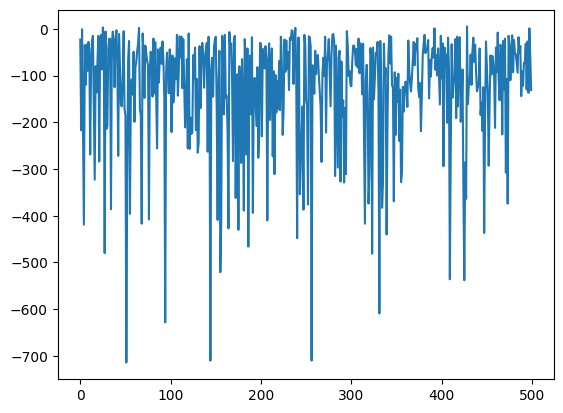

In [ ]:
# Initialize environment and agent
environment = GridWorld()
random_agent = RandomAgent()

reward_per_episode = play(environment, random_agent, trials=500)

# Simple learning curve
plt.plot(reward_per_episode)

## Q-Agent

- Here the Q-Learning agent is ran for 500 trials again
- Performance is plotted
- Performance increases greatly

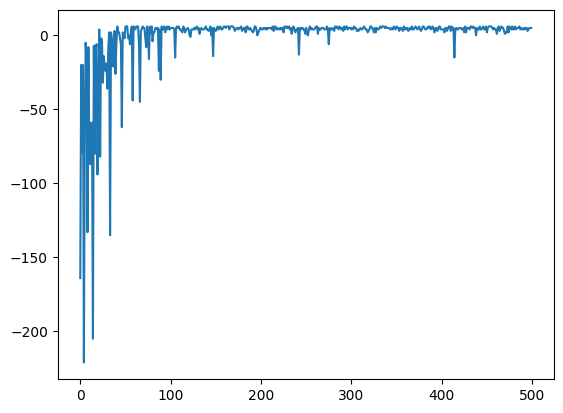

In [ ]:
environment = GridWorld()
agentQ = Q_Agent(environment)

# Note the learn=True argument!
reward_per_episode = play(environment, agentQ, trials=500, learn=True)

# Simple learning curve
plt.plot(reward_per_episode)

Print the final Q-value table with nice formatting.

In [ ]:
def pretty(d, indent=0):
    for key, value in d.items():
        print('\t' * indent + str(key))
        if isinstance(value, dict):
            pretty(value, indent+1)
        else:
            print('\t' * (indent+1) + str(value))


pretty(agentQ.q_table)

(0, 0)
	UP
		-0.30000000000000004
	DOWN
		-0.30900000000000005
	LEFT
		-0.30000000000000004
	RIGHT
		-0.34561000000000003
(0, 1)
	UP
		-0.2
	DOWN
		-0.21
	LEFT
		-0.2
	RIGHT
		2.237957516758934
(0, 2)
	UP
		5.977335735762843
	DOWN
		2.678560690039329
	LEFT
		-0.06367610733785954
	RIGHT
		9.999999999999993
(0, 3)
	UP
		0
	DOWN
		0
	LEFT
		0
	RIGHT
		0
(0, 4)
	UP
		0.171
	DOWN
		-0.1
	LEFT
		9.282102012308147
	RIGHT
		-0.1
(0, 5)
	UP
		-0.2
	DOWN
		-0.2
	LEFT
		2.828264460650381
	RIGHT
		-0.2
(0, 6)
	UP
		-0.4
	DOWN
		-0.42710000000000004
	LEFT
		-0.11190680699616862
	RIGHT
		-0.41081
(0, 7)
	UP
		-0.5
	DOWN
		-0.53203
	LEFT
		-0.553574479183139
	RIGHT
		-0.5
(1, 0)
	UP
		-0.47100000000000003
	DOWN
		-0.5761732876466394
	LEFT
		-0.49820000000000003
	RIGHT
		-0.44590888222121633
(1, 1)
	UP
		-0.29000000000000004
	DOWN
		-0.328
	LEFT
		-0.319
	RIGHT
		4.755824547729072
(1, 2)
	UP
		8.999999999999986
	DOWN
		3.4609686131562247
	LEFT
		1.041197497498565
	RIGHT
		-5.217031
(1, 3)
	UP
		0
	DOW

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque

In [ ]:
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.layers(x)


In [ ]:
class DQNAgent:
    def __init__(self, state_dim, action_dim, epsilon=0.1, lr=0.001, gamma=1.0):
        self.epsilon = epsilon
        self.gamma = gamma
        self.action_dim = action_dim

        self.model = QNetwork(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.criterion = nn.MSELoss()

        self.memory = deque(maxlen=2000)
        self.batch_size = 64

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_dim)
        state_t = torch.FloatTensor(state).unsqueeze(0)
        q_values = self.model(state_t)
        return torch.argmax(q_values).item()

    def remember(self, s, a, r, s_next, done):
        self.memory.append((s, a, r, s_next, done))

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        s, a, r, s_next, done = zip(*batch)

        s = torch.FloatTensor(s)
        a = torch.LongTensor(a)
        r = torch.FloatTensor(r)
        s_next = torch.FloatTensor(s_next)
        done = torch.FloatTensor(done)

        q_values = self.model(s)
        next_q_values = self.model(s_next)

        q_target = q_values.clone()
        for i in range(self.batch_size):
            q_target[i, a[i]] = r[i] + self.gamma * torch.max(next_q_values[i]) * (1 - done[i])

        loss = self.criterion(q_values, q_target.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()



In [ ]:
def train_dqn(env, agent, episodes=500):
    rewards = []
    for ep in range(episodes):
        env.__init__()
        s = np.array(env.current_location, dtype=np.float32)
        total_reward = 0

        for step in range(200):
            a = agent.get_action(s)
            action_name = env.actions[a]
            reward = env.make_step(action_name)
            s_next = np.array(env.current_location, dtype=np.float32)
            done = env.check_state() == 'TERMINAL'

            agent.remember(s, a, reward, s_next, done)
            agent.replay()

            s = s_next
            total_reward += reward
            if done:
                break
        rewards.append(total_reward)
    return rewards


In [ ]:
epsilons = [0.1, 0.5, 0.9]
results = {}

for eps in epsilons:
    env = GridWorld()
    agent = DQNAgent(state_dim=2, action_dim=4, epsilon=eps)
    rewards = train_dqn(env, agent, episodes=500)
    results[eps] = rewards


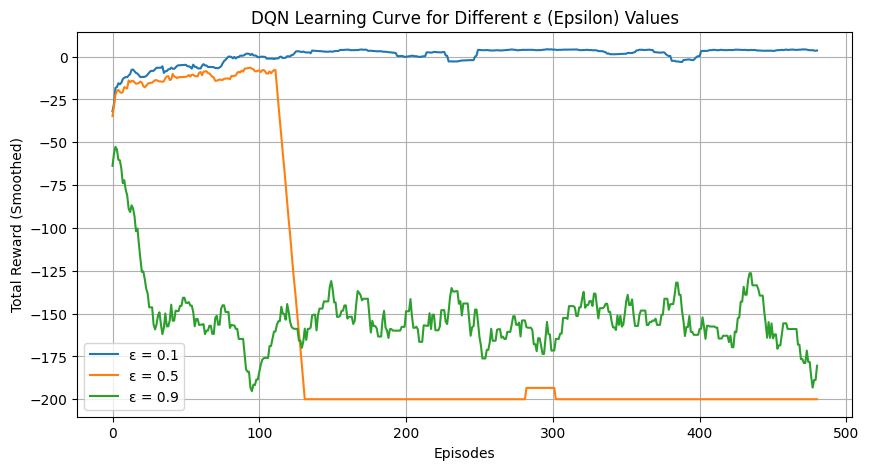

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,5))

# Plot smoothed learning curves for each epsilon value
for eps, rewards in results.items():
    # Smooth the curve using a simple moving average
    smoothed = np.convolve(rewards, np.ones(20)/20, mode='valid')
    plt.plot(smoothed, label=f"ε = {eps}")

plt.title("DQN Learning Curve for Different ε (Epsilon) Values")
plt.xlabel("Episodes")
plt.ylabel("Total Reward (Smoothed)")
plt.legend()
plt.grid(True)
plt.show()
